In [7]:
import matplotlib
matplotlib.use('Agg')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Helpers
import sys
sys.path.insert(0,'../../')
from utils import data_path,results_path,grid_search,estimator_result,cross_validate,evaluate_param
from scipy.sparse import csr_matrix,save_npz,load_npz
from sklearn.model_selection import cross_val_score,LeaveOneOut,StratifiedKFold
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pickle

# Feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV,VarianceThreshold

# Algorithm
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Load data

In [2]:
train_X = load_npz(data_path + 'version_1/'+ 'train_bin.npz')
test_X = load_npz(data_path + 'version_1/'+ 'test_bin.npz')

train_y = pd.read_csv(data_path + 'train_Y.csv')['CMV_status']
test_y = pd.read_csv(data_path + 'test_Y.csv')['CMV_status']

with open(data_path + 'sorted_TCRs_ind.pkl', 'rb') as f:
    TCRs_ind = pickle.load(f)
    
p = 1000
ind = TCRs_ind[:p]
train_X_sub = train_X[:,ind].toarray()
test_X_sub = test_X[:,ind].toarray()

## Feature selection using SelectFromModel

### L1-based

In [17]:
# Logistic Regression
lr = LogisticRegressionCV([0.001,0.01,0.1,1,10,100],penalty='l1',solver='liblinear',random_state=0,refit=True).fit(train_X_sub,train_y)

# Linear SVC
lsvc = LinearSVC(penalty="l1", dual=False,random_state=0).fit(train_X_sub, train_y)

lr_coef_ind = np.argsort(np.abs(lr.coef_.flatten()))[::-1]
lsvc_coef_ind = np.argsort(np.abs(lsvc.coef_.flatten()))[::-1]

print(len(np.nonzero(lr.coef_.flatten())[0]),len(np.nonzero(lsvc.coef_.flatten())[0]))

277 236


In [18]:
# Select from LR
model = SelectFromModel(lr,prefit=True)
train_new = model.transform(train_X_sub)
test_new = model.transform(test_X_sub)
train_new.shape

(641, 277)

In [19]:
lr2 = LogisticRegression(random_state=0)
lr2.fit(train_new,train_y)
print('acc:',accuracy_score(test_y,lr2.predict(test_new)))
print('auroc:',roc_auc_score(test_y,lr2.predict_proba(test_new)[:,1]))

acc: 0.7416666666666667
auroc: 0.7911338448422848


In [20]:
# Select from LinearSVC
model2 = SelectFromModel(lsvc, prefit=True)
train_new2 = model2.transform(train_X_sub)
test_new2 = model2.transform(test_X_sub)
train_new2.shape

(641, 236)

In [21]:
svc = SVC(kernel='linear',probability=True,random_state=0).fit(train_new2, train_y)
svc.fit(train_new2,train_y)
print('acc:',accuracy_score(test_y,svc.predict(test_new2)))
print('auroc:',roc_auc_score(test_y,svc.predict_proba(test_new2)[:,1]))

acc: 0.6916666666666667
auroc: 0.7675475987496448


In [22]:
# Get indices of selected features
ind = model.get_support(indices=True)
ind2 = model2.get_support(indices=True)

In [40]:
with open(data_path + 'feature_selection/'+'bin/'+'lr', 'wb') as f:
    pickle.dump(ind, f, pickle.HIGHEST_PROTOCOL)
with open(data_path + 'feature_selection/'+'bin/'+'lsvc', 'wb') as f:
    pickle.dump(ind2, f, pickle.HIGHEST_PROTOCOL)

### Tree-based

### RandomForest

In [25]:
rf = RandomForestClassifier(n_estimators=100,random_state=0)
rf.fit(train_X_sub,train_y)
rf_im = np.argsort(rf.feature_importances_)[::-1]

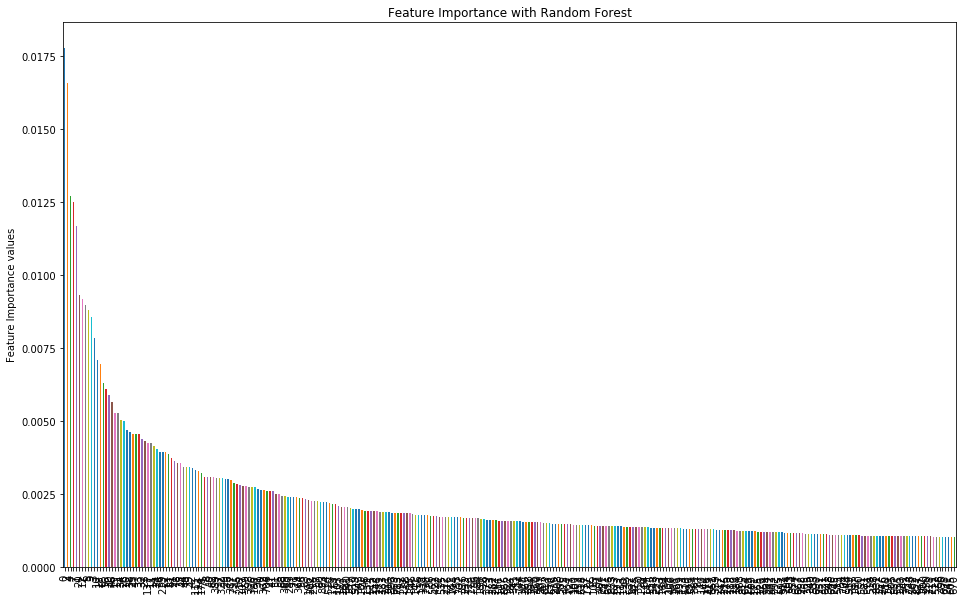

In [29]:
# Plot the feature importances
imp_feat_rf = pd.Series(rf.feature_importances_).sort_values(ascending=False)
imp_feat_rf[:300].plot(kind='bar', title='Feature Importance with Random Forest', figsize=(16,12))
plt.ylabel('Feature Importance values')
plt.subplots_adjust(bottom=0.25)
# plt.savefig('FeatImportance.png')
plt.show()

In [42]:
model3 = SelectFromModel(rf,prefit=True,threshold=1e-3)
train_new3 = model3.transform(train_X_sub)
test_new3 = model3.transform(test_X_sub)
print(train_new4.shape)

(641, 304)


In [49]:
rf2 = RandomForestClassifier(n_estimators=100,random_state=0)
rf2.fit(train_new3,train_y)
print('acc:',accuracy_score(test_y,rf2.predict(test_new3)))
print('auroc:',roc_auc_score(test_y,rf2.predict_proba(test_new3)[:,1]))

acc: 0.825
auroc: 0.8836317135549873


In [44]:
ind3 = model3.get_support(indices=True)

In [46]:
with open(data_path + 'feature_selection/'+'bin/'+'rf', 'wb') as f:
    pickle.dump(ind4, f, pickle.HIGHEST_PROTOCOL)

### Intersection

In [56]:
inter = list(set(ind).intersection(ind2))
inter2 = list(set(ind).intersection(ind3))
inter3 = list(set(ind2).intersection(ind3))

inter_all = list(set(ind).intersection(ind2).intersection(ind3))
print(len(inter),len(inter2),len(inter3),len(inter_all))

217 165 141 136


## Test Performance

In [58]:
inds = {'lr':ind,'lsvc':ind2,'rf':ind3,'inter_lr_lsvc':inter,'inter_lr_rf':inter2,'inter_lsvc_rf':inter3,
       'inter_all':inter_all}

In [67]:
def test_sub_features(clf,dict_inds):
    for name in dict_inds:
        print('Features selected by {}'.format(name))
        print('Len: ',len(dict_inds[name]))
        ind = dict_inds[name]
        clf.fit(train_X_sub[:,ind],train_y)
        print('acc:',accuracy_score(test_y,clf.predict(test_X_sub[:,ind])))
        print('auroc:',roc_auc_score(test_y,clf.predict_proba(test_X_sub[:,ind])[:,1]))
        print()

In [68]:
test_sub_features(lr2,inds)

Features selected by lr
Len:  277
acc: 0.7416666666666667
auroc: 0.7911338448422848

Features selected by lsvc
Len:  236
acc: 0.75
auroc: 0.7971014492753623

Features selected by rf
Len:  304
acc: 0.7583333333333333
auroc: 0.8300653594771241

Features selected by inter_lr_lsvc
Len:  217
acc: 0.725
auroc: 0.7934072179596476

Features selected by inter_lr_rf
Len:  165
acc: 0.75
auroc: 0.8098891730605285

Features selected by inter_lsvc_rf
Len:  141
acc: 0.7333333333333333
auroc: 0.8036373969877806

Features selected by inter_all
Len:  136
acc: 0.7583333333333333
auroc: 0.7990906507530549



In [70]:
test_sub_features(rf,inds)

Features selected by lr
Len:  277
acc: 0.75
auroc: 0.8277919863597613

Features selected by lsvc
Len:  236
acc: 0.725
auroc: 0.8110258596192099

Features selected by rf
Len:  304
acc: 0.825
auroc: 0.8836317135549873

Features selected by inter_lr_lsvc
Len:  217
acc: 0.7166666666666667
auroc: 0.807899971582836

Features selected by inter_lr_rf
Len:  165
acc: 0.7666666666666667
auroc: 0.8319124751349817

Features selected by inter_lsvc_rf
Len:  141
acc: 0.7583333333333333
auroc: 0.8131571469167378

Features selected by inter_all
Len:  136
acc: 0.7583333333333333
auroc: 0.8208297811878376

